Importing Python Libraries



In [1]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from itertools import count

Creating a function to reads all the jpg file from a specific location
and returns the images, and the number of images read

In [2]:
def read_images(path):
    images = []
    n = 0
    for fname in glob.glob(os.path.join(path, '*.jpg')):
        image = cv2.imread(fname)
        images.append(image)
        n+=1
    return images, n

Creating a function to takes a threat image then crops it tightly then it finds the maximum amoung the height and width then it adds black borders depending on the maximum to make the threat a squareimage

In [3]:
def form_square(image):
    rowsum = np.sum(image, axis = (1,2))
    colsum = np.sum(image, axis = (0,2))
    left = 0
    right = 0
    top = 0
    bottom = 0
    for i,v in enumerate(rowsum):
        if v>0:
            top = i
            break
    for i, v in zip(count(len(rowsum) - 1, -1), reversed(rowsum)):
        if v>0:
            bottom = i
            break
    for i,v in enumerate(colsum):
        if v>0:
            left = i
            break
    for i, v in zip(count(len(colsum) - 1, -1), reversed(colsum)):
        if v>0:
            right = i
            break
    cropped = image[top:bottom,left:right,:]
    (h, w) = cropped.shape[:2]
    new = np.zeros((max([h,w]),max([h,w]),3), np.uint8)
    if(h>w):
        diff = (h-w)//2
        new[:,diff:diff+w,:] = new[:,diff:diff+w,:]+cropped
        return new
    elif(w>h):
        diff = (w-h)//2
        new[diff:diff+h,:,:] = new[diff:diff+h,:,:]+cropped
        return new
    else:
        new = cropped
    return new

Adding dynamic padding to an image

In [4]:
def pad_image(image):
    (h, w) = image.shape[:2]
    l = int((h*h+w*w)**0.5)
    padded = np.zeros((l, l, 3), np.uint8)
    padded[(l-h)//2:(l-h)//2+h, (l-w)//2:(l-w)//2+w, :] = image
    return padded


Taking a background and threat image amd rescales the threat image 
An optional argument is percent_factor

In [5]:
def autoscaler(background, threat, percent_factor = 0.4):
    (hb, wb) = background.shape[:2]
    areatb = hb*wb
    l = int((hb*hb+wb*wb)**0.5)
    l = int((areatb//l)*percent_factor)
    threat = cv2.resize(threat, (l,l), cv2.INTER_AREA)
    return threat

Dynamically returns the x,y position the centroid of the largest contour in the background

In [6]:
def get_xy(background):
    lower_white = np.array([245,245,245])  
    upper_white = np.array([255,255,255])
    edged = cv2.inRange(background, lower_white, upper_white)
    edged = cv2.bitwise_not(edged)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE )
    c = max(contours, key = cv2.contourArea)
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return cX, cY

placing the threat object in the background at a certain x,y position in the background

In [7]:
def place_threat(background, threat, x=0, y=0):
    (ht, wt) = threat.shape[:2]
    (hb, wb) = background.shape[:2]
    
    if(x+ht>hb or y+wt>wb):
        raise Exception("Threat size and position incompatible with background.")
    
    for row in range(ht):
        for col in range(wt):
            if(np.sum(threat[row, col,:])>0):
                background[row+x,col+y,:] = threat[row, col,:]
                
    return background

location of threat images and background images

In [8]:
threat_path = 'F:/Python/Data Science/Internshala/Dimensionless Technologies/BaggageAI_CV_Hiring_Assignment/threat_images/'
background_path = 'F:/Python/Data Science/Internshala/Dimensionless Technologies/BaggageAI_CV_Hiring_Assignment/background_images/'
save_locaion = 'F:/Python/Data Science/Internshala/Dimensionless Technologies/BaggageAI_CV_Hiring_Assignment/output_result_images/'
rotate_angle = 45
# threshold level for white
lower_white = np.array([245,245,245])  
upper_white = np.array([255,255,255])
# percent factor for resizing threat
percent_factor = 0.4

reading all files from location

In [9]:
threats, num_threats = read_images(threat_path)
backgrounds, num_background = read_images(background_path)
n = 0

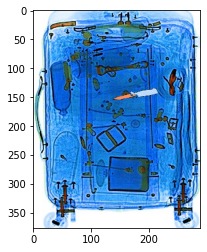

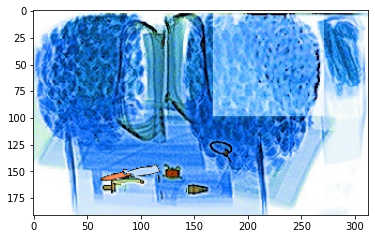

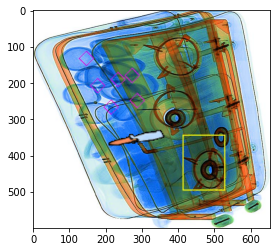

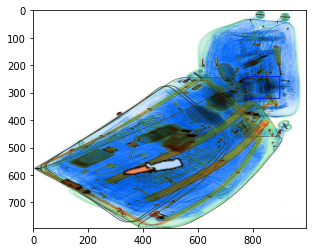

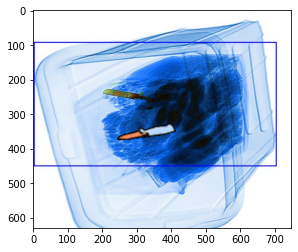

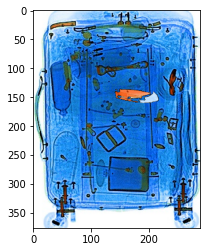

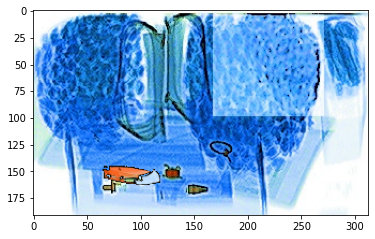

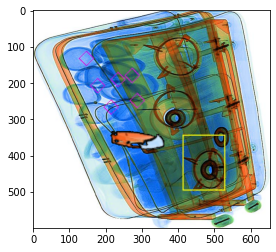

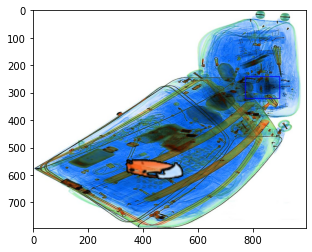

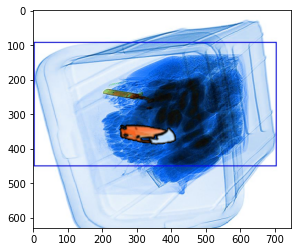

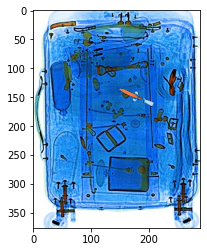

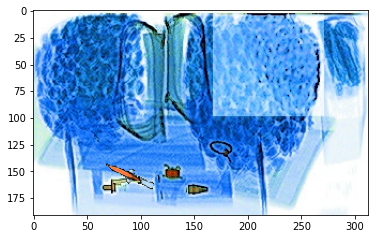

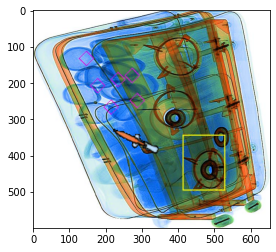

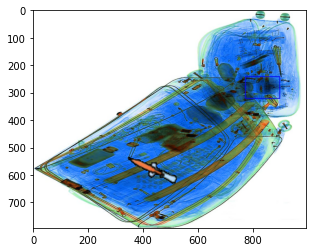

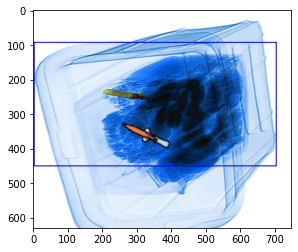

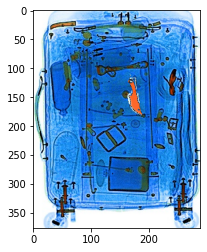

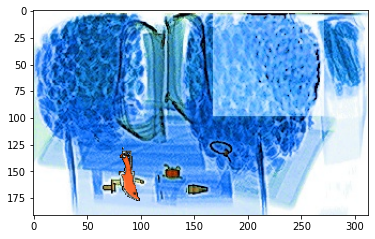

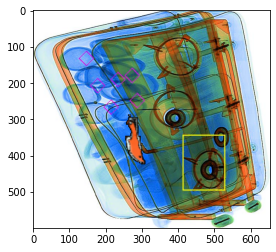

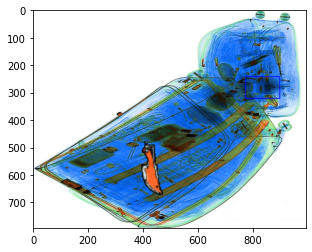

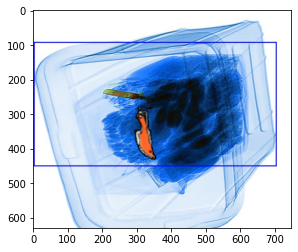

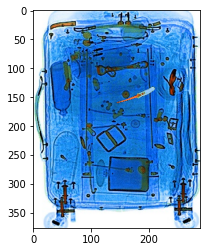

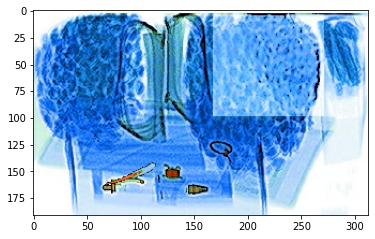

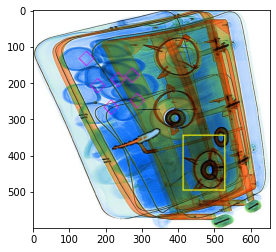

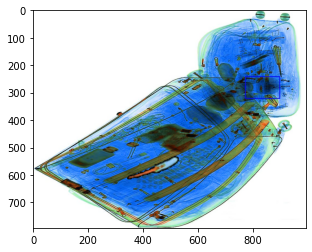

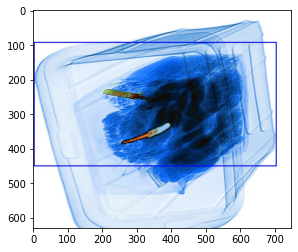

In [10]:
for image in threats:
    image_copy = np.copy(image)
    kernelmatrix = np.ones((5, 5), np.uint8)
    image_copy = cv2.dilate(image_copy, kernelmatrix)
    # defining the mask
    mask = cv2.inRange(image_copy, lower_white, upper_white)
    
    masked_image = np.copy(image)
    masked_image[mask != 0] = [0, 0, 0]
    cropped = form_square(masked_image)
    cropped = pad_image(cropped)
    (h, w) = cropped.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), rotate_angle, 1.0)
    rotated = cv2.warpAffine(cropped, M, (w, h))
    
    for background in backgrounds:
        temp = np.copy(background)
        rotated = autoscaler(temp, rotated, percent_factor=percent_factor)
        (h, w) = rotated.shape[:2]
        x,y = get_xy(temp)
        x = x-h//2
        y = y-w//2
        temp = place_threat(temp, rotated, x=x, y=y)
        n+=1
        cv2.imwrite(save_locaion+str(n)+'.jpg', temp)
        plt.imshow(temp)
        plt.show()